# Маркетинговое исследование приложения Procrastinate Pro+

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. **Задача** — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

**Стоит изучить:**
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

## Шаг 1. Загрузка данных и подготовка к анализу

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, date, timedelta
from scipy import stats as st
# отображаем все колонки датафреймов
pd.set_option("display.max_columns", 30)

In [2]:
# загружаем файлы с данными
try:
    visits = pd.read_csv("games.csv")
    orders = pd.read_csv("games.csv")
    costs = pd.read_csv("games.csv")
except:
    visits = pd.read_csv("/datasets/visits_info_short.csv")
    orders = pd.read_csv("/datasets/orders_info_short.csv")
    costs = pd.read_csv("/datasets/costs_info_short.csv")

In [3]:
# функция для знакомства с данными и приведения столбцов к нижнему регистру
def info(data):
    data.columns = data.columns.str.lower()
    data.columns = [x.lower().replace(' ', '_') for x in data.columns]
    data.info()
    print('*'*50)
    display(data.describe())
    print('*'*50)
    display(data.sample(n=10, random_state=10))
    display(data.duplicated().sum())

Познакомимся с каждой из загруженных таблиц.

In [4]:
info(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
**************************************************


,user_id
count,3.099010e+05
mean,4.997664e+11
std,2.887899e+11
min,5.993260e+05
25%,2.493691e+11
50%,4.989906e+11
75%,7.495211e+11
max,9.999996e+11


**************************************************


,user_id,region,device,channel,session_start,session_end
209026,200153959279,Germany,Mac,organic,2019-05-05 09:41:51,2019-05-05 09:44:23
229979,795367275477,UK,Android,LeapBob,2019-06-17 20:29:55,2019-06-17 20:58:31
178679,833418121699,United States,Android,FaceBoom,2019-10-08 14:43:04,2019-10-08 14:45:01
165551,809555132475,United States,Android,organic,2019-09-29 15:57:52,2019-09-29 17:02:05
38660,370953998590,United States,Android,RocketSuperAds,2019-06-09 10:46:32,2019-06-09 12:00:57
10702,387592277004,United States,Android,organic,2019-05-12 06:22:19,2019-05-12 06:44:31
132435,293352760537,United States,Mac,organic,2019-09-03 10:16:40,2019-09-03 10:19:24
170952,101396729529,United States,iPhone,RocketSuperAds,2019-10-03 08:26:03,2019-10-03 08:29:29
17674,787109051013,United States,Mac,organic,2019-05-19 23:13:47,2019-05-19 23:17:34
222690,250551701184,UK,Mac,organic,2019-05-31 11:03:35,2019-05-31 11:22:58


0

Таблица `visits` состоит из следующих столбцов:
 - `User Id` — уникальный идентификатор пользователя
 - `Device` — категория устройства пользователя
 - `Session start` — дата и время начала сессии
 - `Session End` — дата и время окончания сессии
 - `Channel` — идентификатор рекламного источника, из которого пришел пользователь
 - `Region` - страна пользователя.
 
Данные в таблице `visits` выглядят более-менее нормально, дуликатов нет, пропусков нет, единственное необходимо изменить тип данных у столбцов со временем на соответствующий и привести названия столбцов к "змеиному" регистру. Посмотрим какие каналы привлечения есть в столбце `Channel`, какие страны представлены в столбце `Region` и какие устройства представлены в колонке `Device`.

In [5]:
display(visits['region'].value_counts())
display(visits['channel'].value_counts())
display(visits['device'].value_counts())

United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64

organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: channel, dtype: int64

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

In [6]:
info(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
**************************************************


,user_id,revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


**************************************************


,user_id,event_dt,revenue
13343,142279100109,2019-08-19 01:35:03,4.99
12603,283678829664,2019-08-15 01:29:37,4.99
36911,404969463048,2019-09-29 08:59:44,4.99
38284,773620039300,2019-10-12 00:52:29,4.99
32043,414817784904,2019-07-31 14:23:33,4.99
3039,503702240061,2019-06-10 01:16:49,4.99
38731,560402030605,2019-10-17 17:39:07,4.99
30288,727753351469,2019-07-02 10:07:43,4.99
23480,311381168274,2019-10-11 17:42:01,4.99
2411,971239099811,2019-06-04 18:51:43,4.99


0

Таблица `orders` состоит из:
- `User Id` — уникальный id пользователя, который сделал заказ
- `Event Dt` — дата и время покупки
- `Revenue` — выручка

В этой таблице также нужно привести колонку с датами к правильному типу данных и добавить нижнее подчеркивание в название столбцов. Дубликатов нет.

In [7]:
info(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
**************************************************


,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


**************************************************


,dt,channel,costs
764,2019-06-14,YRabbit,3.78
278,2019-08-07,MediaTornado,3.60
1538,2019-08-07,WahooNetBanner,28.20
1780,2019-10-08,lambdaMediaAds,11.20
123,2019-09-01,FaceBoom,221.10
1621,2019-05-02,lambdaMediaAds,16.80
270,2019-07-30,MediaTornado,3.84
1562,2019-08-31,WahooNetBanner,31.80
962,2019-07-02,AdNonSense,22.05
130,2019-09-08,FaceBoom,144.10


0

Таблица `costs`:
- `Channel` — идентификатор рекламного источника
- `Dt` — дата
- `Costs` — затраты на этот рекламный источник в этот день
    
Также необходимо изменить тип у колонки с датами. Посмотрим какие в этой таблице представлены каналы привлечения.

In [8]:
display(costs['channel'].unique())

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

In [10]:
# меняем типы данных с object на datetime во всех трех таблицах
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders["event_dt"] = pd.to_datetime(orders["event_dt"])

costs["dt"] = pd.to_datetime(costs["dt"])

**Вывод:**

В качестве входных данных у нас имеется три таблицы: лог сервера с данными об их посещениях, выгрузка их покупок за этот период, рекламные расходы. Данные довольно чистые, нет пропусков и полных дубликатов. Тип данных у колонок с датами сменили на `datetime`, чтоб дальше удобнее было работать, также привели названия столбцов к нижнему регистру.

## Шаг 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии

### Функция для создания пользовательских профилей

Для создания пользовательских профилей будет использована функция **get_profiles()**. В ней сгруппируем значения датафрейма по пользовательскому ID и применим функцию first():

In [11]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    ad_costs['dt'] = ad_costs['dt'].dt.date
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles
 

### Функция для расчёта удержания

Для расчёта коэффициента удержания понадобится функция **get_retention()**.
Её аргументы:
`profiles` — профили пользователей,
`sessions` — данные журнала сессий,
`observation_date` — момент анализа,
`horizon_days` — горизонт анализа в днях,
-`dimensions=[]` - ддополнительный парметр группировки,
`ignore_horizon` — опция «игнорировать горизонт анализа», по умолчанию False.

In [12]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для расчёта конверсии

Для расчета конверсии используем функцию **get_conversion()**. Аргументы: 
`profiles` — профили пользователей,
`purchases` — данные о покупках,
`observation_date` — момент анализа,
`horizon_days` — горизонт анализа в днях,
-`dimensions=[]` - ддополнительный парметр группировки,
`ignore_horizon` — опция «игнорировать горизонт анализа», по умолчанию False.

In [13]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для расчета "пожизненной ценности" и окупаемости инвестиций

Функция для расчета "пожизненной ценности" и окупаемости инвестиций **get_ltv()**.

In [14]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Функция для визуализации метрик

Функции для визуализации метрик — **filter_data()**, **plot_retention()**, **plot_conversion()** и **plot_ltv_roi()**

In [15]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [16]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=30):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    
    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [17]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [18]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(15, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(3, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(3, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(3, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(3, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(3, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Шаг 3. Исследовательский анализ данных

### Профили пользователей

С помощью функции **get_profiles()** создадим профили пользователей. 

In [19]:
profiles = get_profiles(visits, orders, costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


Результат — 150008 пользовательских профилей, в каждом из которых есть данные о дате первого посещения и рекламном источнике, который мотивировал пользователя посетить интернет-магазин. Такие данные значительно упрощают дальнейший анализ.

In [20]:
# определим минимальную и максимальную даты привлечения пользователей
display('Минимальная дата привлечения:', profiles['dt'].min())
display('Максимальная дата привлечения:' , profiles['dt'].max())

'Минимальная дата привлечения:'

datetime.date(2019, 5, 1)

'Максимальная дата привлечения:'

datetime.date(2019, 10, 27)

В датафрейме представлены данные о привлеченных пользователях с 1 мая по 27 октября 2019года. Как и было заявлено в задании.

### Распределение платящих пользователей по странам

In [44]:
display(
    profiles.groupby('region')
    .agg({'user_id' : 'count', 'payer': 'mean'})
    .sort_values(by = 'payer', ascending = False).style.format({'payer': '{:.4f}'})
)

,user_id,payer
region,,
United States,100002,0.0690
Germany,14981,0.0411
UK,17575,0.0398
France,17450,0.0380


В приложение пользователи приходят из 4 стран: `Америка`, `Германия`, `Великобритания` и `Франция`. Наибольшая доля пользователей становится плательщиками в `Америке` и в этой стране наиболее количество пользователей, а наименьшая доля плательщиков во `Франции`. Меньше всего пользователей зарегистрировано в `Германии`.

### Распределение клиентов по устройствам

In [45]:
(profiles.groupby('device')
    .agg({'user_id' : 'count', 'payer': 'mean'})
    .sort_values(by = 'payer', ascending = False).style.format({'payer': '{:.4f}'})
)

,user_id,payer
device,,
Mac,30042,0.0636
iPhone,54479,0.0621
Android,35032,0.0585
PC,30455,0.0505


В приложение пользователи заходят с 4 устройств: `Mac`, `iPhone`, `Android`, `PC`. Больше всего с `iPhone`. На устройстве `Mac` наибольшая доля становится плательщиками.

### Распределение по каналам привлечения

In [46]:
(profiles.groupby('channel')
    .agg({'user_id' : 'count', 'payer': 'mean'})
    .sort_values(by = 'payer', ascending = False).style.format({'payer': '{:.4f}'})
)

,user_id,payer
channel,,
FaceBoom,29144,0.1220
AdNonSense,3880,0.1134
lambdaMediaAds,2149,0.1047
TipTop,19561,0.0960
RocketSuperAds,4448,0.0791
WahooNetBanner,8553,0.0530
YRabbit,4312,0.0383
MediaTornado,4364,0.0357
LeapBob,8553,0.0306


Наибольшее количество пользователей нашло приложение сами, но число платящих среди них очень низкое. Самый эффективный канал привлечения платящих пользователей - `FaceBoom`, более **12** процентов пришедших с этого канала становятся плательщиками.

**Вывод:** 

Мы создали **150008** пользовательских профилей из имеющихся данных за период с **1 мая** по **27 октября 2019года**. 

В приложение пользователи приходят из **4** стран:
- `Америка`,
- `Германия`,
- `Великобритания`
- `Франция`. 

Наибольшая доля пользователей становится плательщиками в `Америке`. 

В приложение пользователи заходят с 4 устройств: 
- `Mac`,
- `iPhone`,
- `Android`,
- `PC`.

Самый эффективный канал привлечения платящих пользователей - `FaceBoom`, более **12** процентов пришедших с этого канала становятся плательщиками.

## Шаг 4. Маркетинг

### Общая сумма расходов на маркетинг, траты по источникам

In [24]:
display('Общая сумма расходов на маркетинг:', round(profiles['acquisition_cost'].sum(), 2))

'Общая сумма расходов на маркетинг:'

105497.3

Посмотрим на изменение расходов во времени.

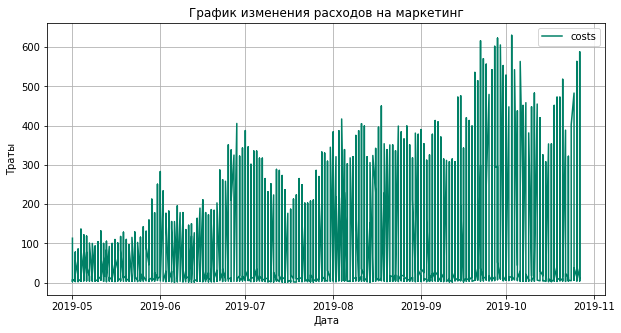

In [47]:
costs.plot(y='costs',
           x='dt',
           figsize=(10, 5), 
           grid=True,                 
           colormap='summer') 

plt.title('График изменения расходов на маркетинг')
plt.xlabel('Дата')
plt.ylabel('Траты')
plt.show()

Видим увеличение расходов на маркетинг с течением времени. В конце сентября - начале октября они достигли пика, после чего стали немного снижаться, а затем к концу октября внось стремились вверх.

Выясним, как траты распределены по источникам.

In [26]:
(profiles.groupby('channel')
    .agg({'acquisition_cost' : 'sum'})
    .sort_values(by = 'acquisition_cost', ascending = False)
    .rename(columns={'acquisition_cost': 'cac'})
)

,cac
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


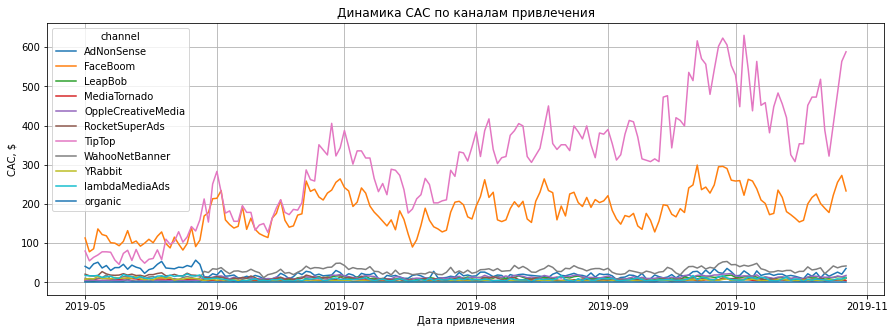

In [27]:
# строим график истории изменений CAC по каналам привлечения
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot(grid=True, figsize=(15, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Стоимость привлечения «органических» пользователей равна нулю, потому что они перешли в приложение самостоятельно, а не благодаря рекламе. Наибольшие суммы для привлечения клиентов по двум каналам `FaceBoom` и `TipTop`. При чем если на начало рассматриваемого периода на `FaceBoom` тратилось больше то где-то с июня траты на `TipTop` стали все больше возрастать. Остальные каналы привлечения обходятся довольно дешево. 

### Средний CAC

In [28]:
display('Средний САС на одного пользователя проекта:', round(profiles['acquisition_cost'].mean(), 2))

'Средний САС на одного пользователя проекта:'

0.7

In [50]:
profiles_not_organic = profiles.query('channel != "organic"')

display('Средний САС на одного платящего пользователя:', round(profiles_not_organic['acquisition_cost'].mean(), 2))

'Средний САС на одного платящего пользователя:'

1.13

Если не брать в расчет среднего пользователей, которые пришли сами, то САС значительно выше **1,13** против **0,7у.е.**

In [55]:
(profiles.groupby('channel')
    .agg({'acquisition_cost' : 'mean'})
    .sort_values(by = 'acquisition_cost', ascending = False)
    .rename(columns={'acquisition_cost': 'cac'}).style.format({'cac': '{:.2f}'})
)

,cac
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Самый дорогой трафик - `TipTop` (средняя стоимость - 2.80 за пользователя), далее идет `FaceBoom` и `AdNonSense` примерно в равной ценовой категории (1.11 и 1.01 соответственно). Органический трафик бесплатен, остальные каналы берут за пользователя от 0.21 до 0.72 у.е.

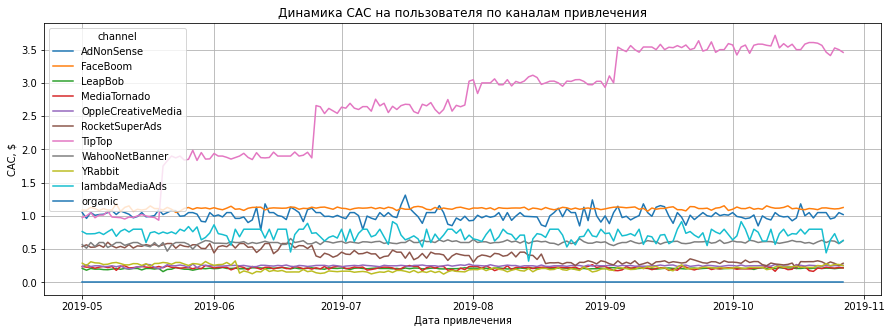

In [30]:
# строим график истории изменений CAC на пользователя по каналам привлечения
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС на пользователя по каналам привлечения')
plt.show()

Так же как и суммарным САС, по среднему САС на пользователя видим что по каналу `organic` стоимость привлечения нулевая. По всем источникам кроме `TipTop` средняя стоимость привлечения стабильна на протяжении всего исследуемого периода. А вот канал привлечения `TipTop` очень интересный. мало того что средняя стоимость привлечения на нем выше чем на других площадках, так еще есть резкие скачки с повышением. Возможно это связано с тем что платформа развивается. становится все популярнее. соответственно стоимость рекламы увеличивается.

**Вывод:**

Общая сумма расходов на маркетинг - **105497.3у.е**. Со временем расходы растут. В конце сентября - начале октября они достигли пика, после чего стали немного снижаться, а затем к концу октября внось стремились вверх. Стоимость привлечения «органических» пользователей равна нулю, потому что они перешли в приложение самостоятельно, а не благодаря рекламе. Наибольшие суммы для привлечения клиентов по двум каналам `FaceBoom` и `TipTop`. При чем если на начало рассматриваемого периода на `FaceBoom` тратилось больше то где-то с июня траты на `TipTop` стали все больше возрастать. Остальные каналы привлечения обходятся довольно дешево. По всем источникам кроме `TipTop` средняя стоимость привлечения стабильна на протяжении всего исследуемого периода. А вот канал привлечения `TipTop` очень интересный. мало того что средняя стоимость привлечения на нем выше чем на других площадках, так еще есть резкие скачки с повышением. Возможно это связано с тем что платформа развивается. становится все популярнее. соответственно стоимость рекламы увеличивается.

## Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

По условию на календаре 1-го ноября 2019 года и окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей. Зададим момент и горизонт анализа.

In [31]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

### Анализ общей окупаемости

Посмотрим окупается ли реклама вцелом.

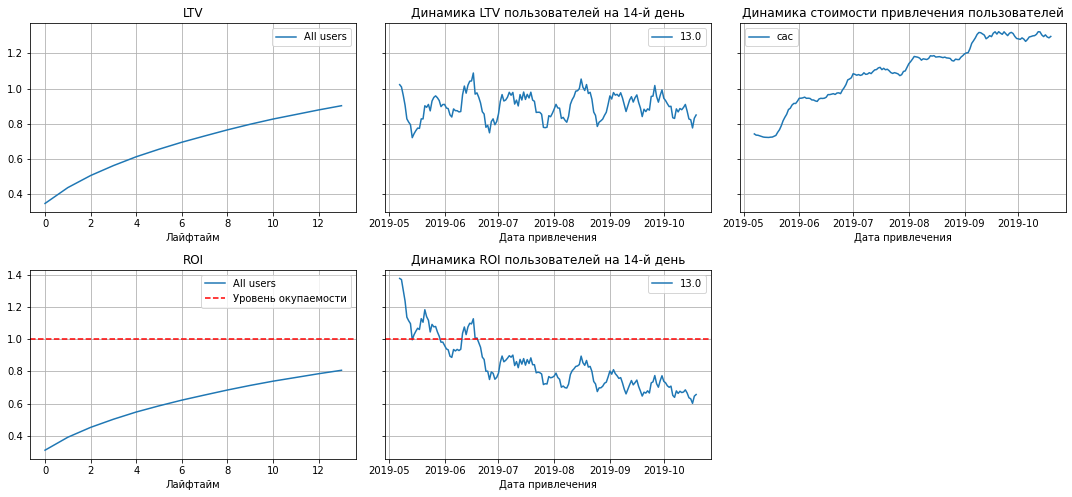

In [57]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_not_organic, 
                                                                      orders, 
                                                                      observation_date,
                                                                      horizon_days,
                                                                      dimensions=[],
                                                                      ignore_horizon=False,
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7) 

По графикам можно сделать такие выводы:
- Реклама не окупается к концу 2й недели. ROI — около 80%.
- CAC нестабилен. Рекламный бюджет увеличивается с течением времени.
- На LTV влияет сезонный фактор, но в целом, этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.
- ROI пользователей неумолимо падает. До июля показатель был выше уровня окупаемости, но после стал падать до 0.6.

Проблема ясна. Денег в рекламу стали вкладывать больше, а "ценность" клиентов не выросла.

### Окупаемость рекламы с разбивкой по устройствам

Чтобы понять что не так посмотрим на окупаемость "в разрезе" устройств.

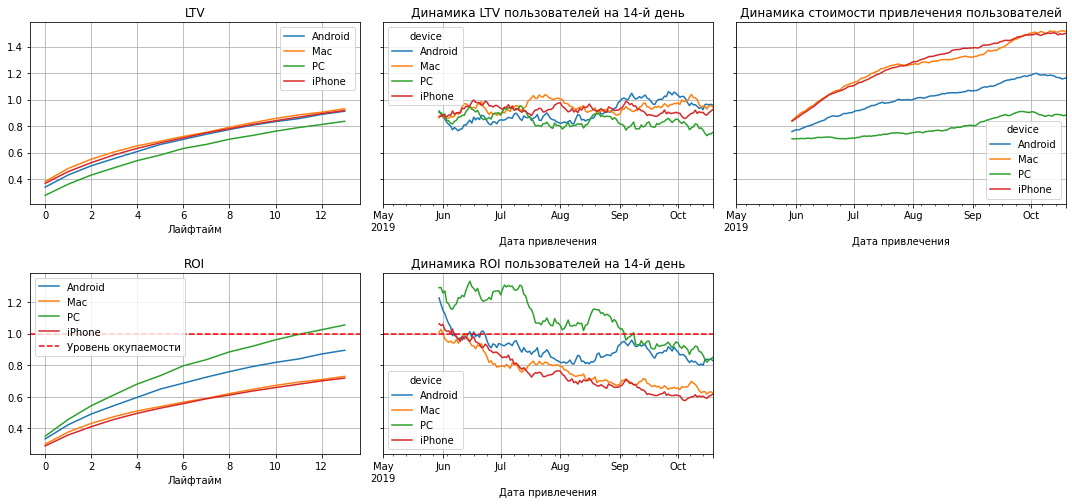

In [59]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_not_organic, 
                                                                      orders, 
                                                                      observation_date,
                                                                      horizon_days,
                                                                      dimensions=['device'],
                                                                      ignore_horizon=False,
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30) 

- LTV пользователей PC немного ниже чем пользователей остальных девайсов.
- Стоимость привлечения пользователей iPhone и Мас очень высока и по графику окупаемости видим что именно эти пользователи не окупаются.
- Лучше всего по окупаемости и в динамике показывает себя РС.
- В целом, видим, что стоимость привлечения пользователей всех устройств росла за рассматриваемый период.

### Графики конверсии и удержания с разбивкой по устройствам

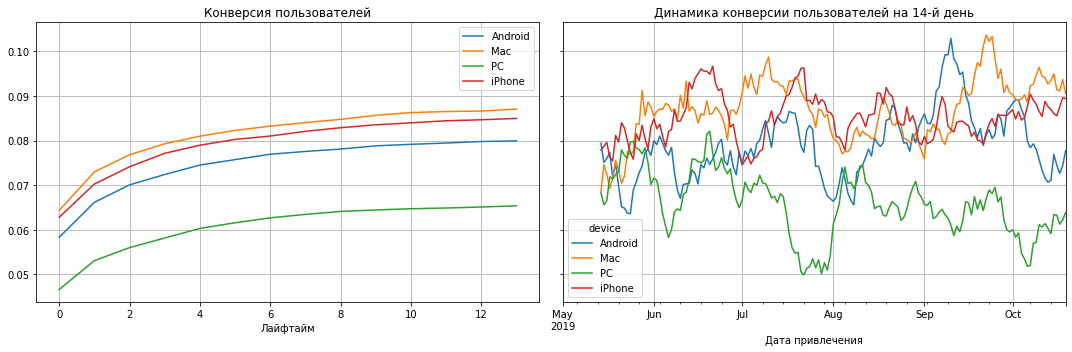

In [60]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_not_organic, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion, conversion_history, horizon_days, window=14)

Судя по графикам, пользователи `Mac`, `Android` и `iPhone` конвертируются хорошо, причём постоянно. Видимо, дело в удержании. Вызовем функции **get_retention()** и **plot_retention()**, чтобы рассчитать и отразить на графиках этот показатель.

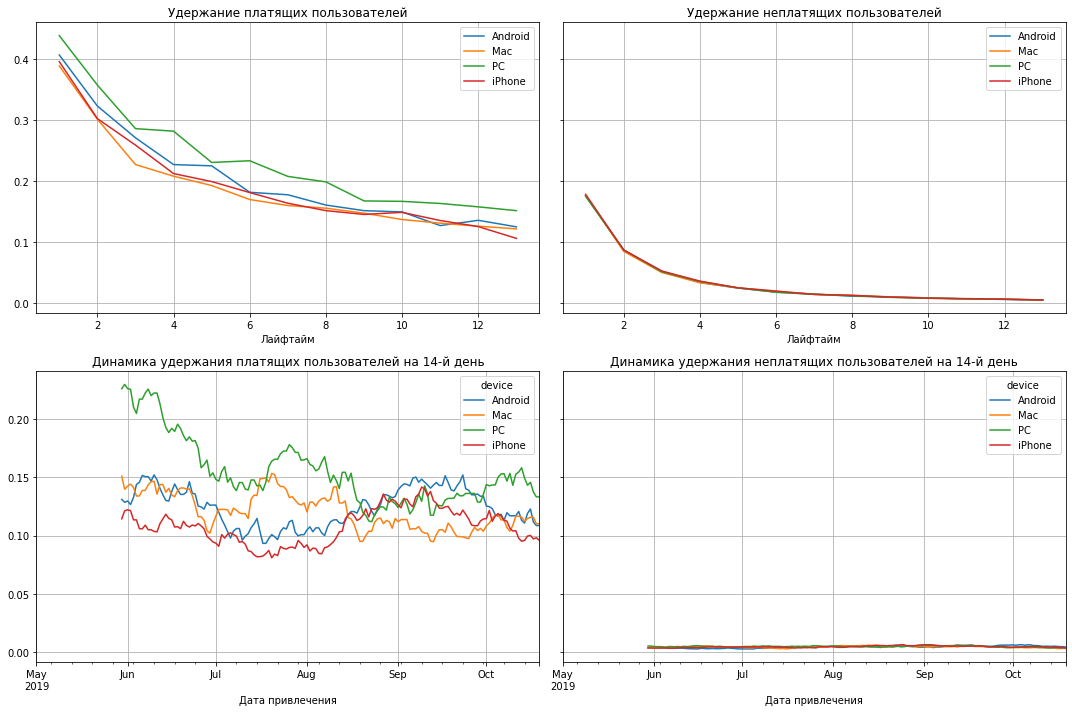

In [35]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device'], ignore_horizon=False
)


plot_retention(retention_grouped, retention_history, horizon_days) 

Не видно, чтобы пользователи каких-то определенных устройств особо плохо удерживались. Неплатящие пользователи удерживаются стабильно плохо, а из платящих лучше всего удерживаются пользователи `PC`, хуже - владельцы `iPhone` и `Mac`.

### Окупаемость рекламы с разбивкой по рекламным каналам

Теперь проверим источники привлечения. Возможно, на окупаемость влияет неудачная реклама в каком-нибудь одном канале.

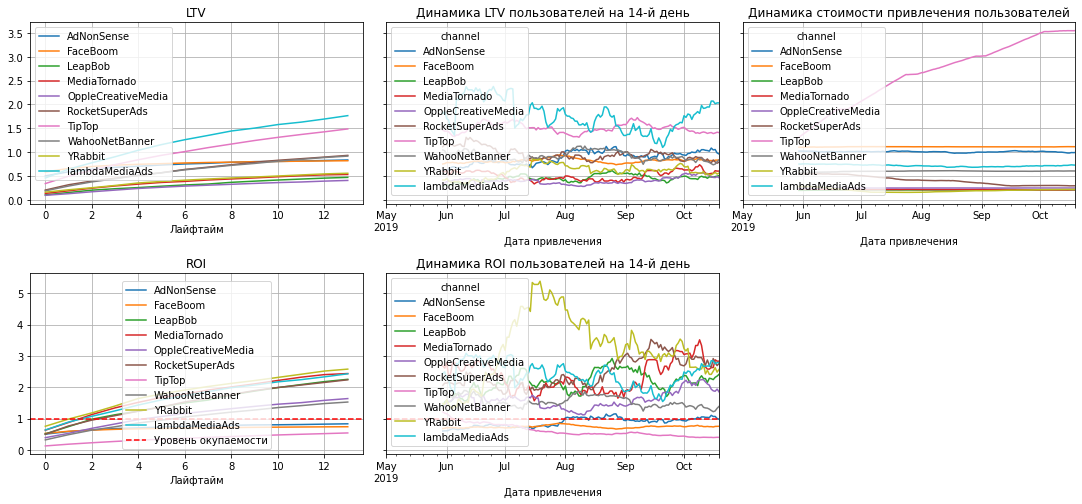

In [61]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_not_organic, 
                                                                      orders, 
                                                                      observation_date,
                                                                      horizon_days,
                                                                      dimensions=['channel'],
                                                                      ignore_horizon=False,
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30) 

- Пользователи, привлеченные из каналов `AdNonSense`, `FaceBoom`, `TipTop` не окупаются.
- Хорошо показала себя в июле(ROI пользователей на 14 день) рекламная сеть `YRabbit` .

### Графики конверсии и удержания с разбивкой по рекламным каналам

Посмотрим удержание и конверсию рекламных каналов.

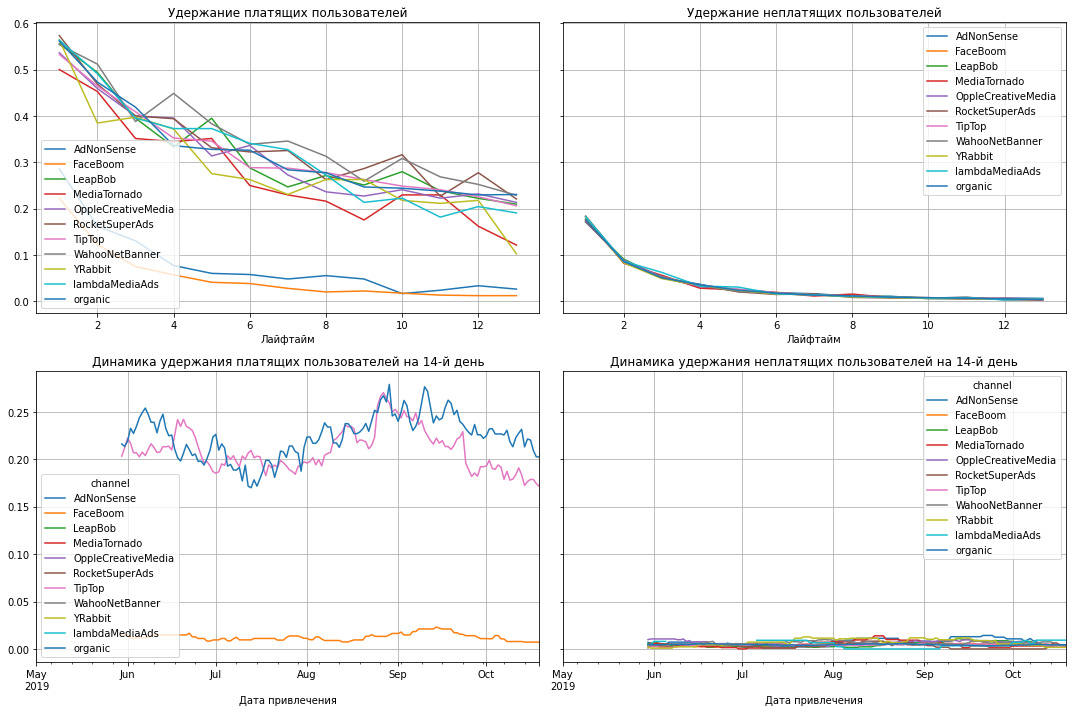

In [37]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel'], ignore_horizon=False
)


plot_retention(retention_grouped, retention_history, horizon_days) 

Плохо удерживаются пользователи из каналов `FaceBoom` и `AdNonSense`. При чем на 14 день удержание пользователей из канала `FaceBoom` стабильно низкое.

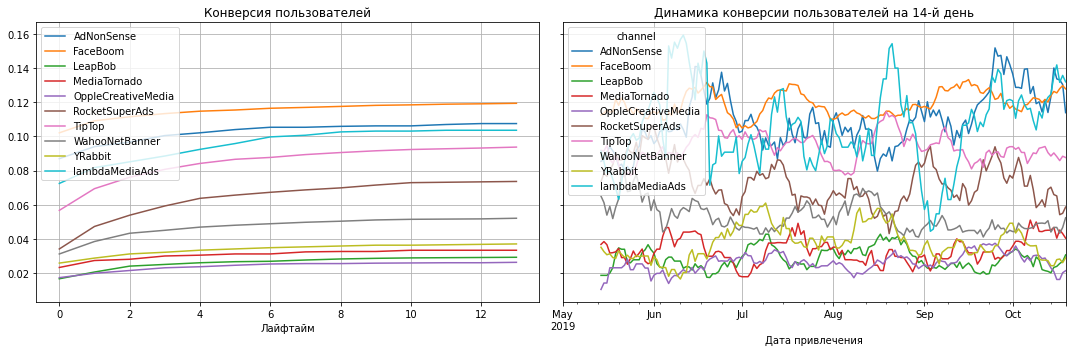

In [62]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_not_organic, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion, conversion_history, horizon_days, window=14)

Плохо конвертируются пользователи из каналов `RocketSuperAds`, `MediaTornado`, `YRabbit`, `OppleCreativeMedia`.

### Окупаемость рекламы с разбивкой по странам

Посмотрим во всех ли странах реклама себя окупает.

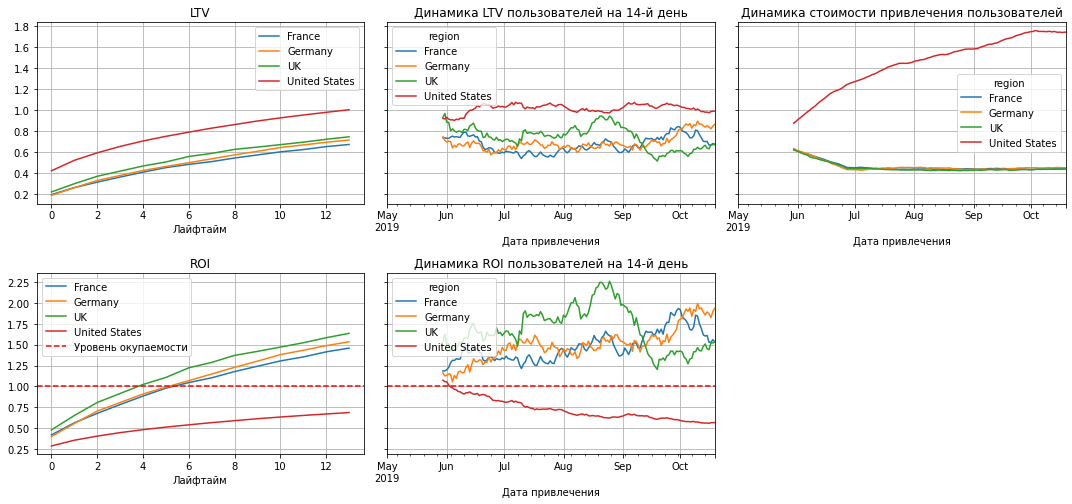

In [63]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_not_organic, 
                                                                      orders, 
                                                                      observation_date,
                                                                      horizon_days,
                                                                      dimensions=['region'],
                                                                      ignore_horizon=False,
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30) 

Сразу бросается в глаза Америка. Динамика стоимости привлечения значительно отличается от остальных стран, пользователи этой страны не окупаются вообще приблизительно с июля, при этом большая часть пользователей именно отсюда. Возможно, неудачный релиз, запуск похожего продукта у конкурентов или какие-то  изменения в продукте сыграли такую роль, и сервис стал менеее привлекательным для пользователей.


### Графики конверсии и удержания с разбивкой по странам

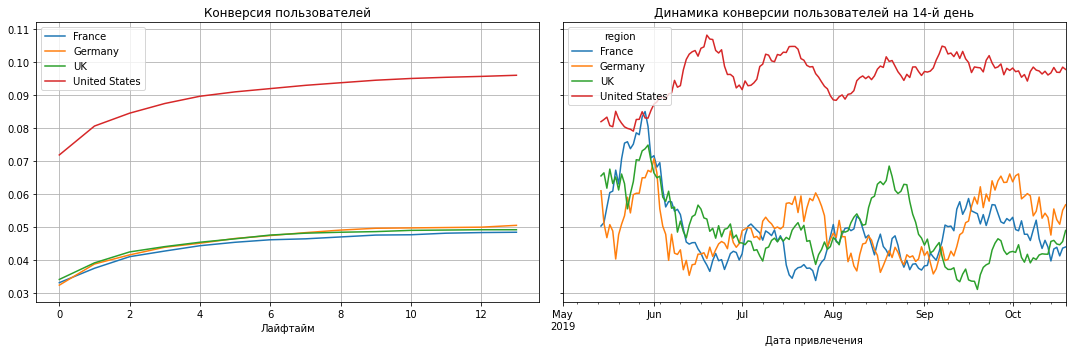

In [64]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_not_organic, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion, conversion_history, horizon_days, window=14)

Слабая конверсия у пользователей из Англии, Германии и Франции. Но и их доля относительно всех пользователей не такая большая.

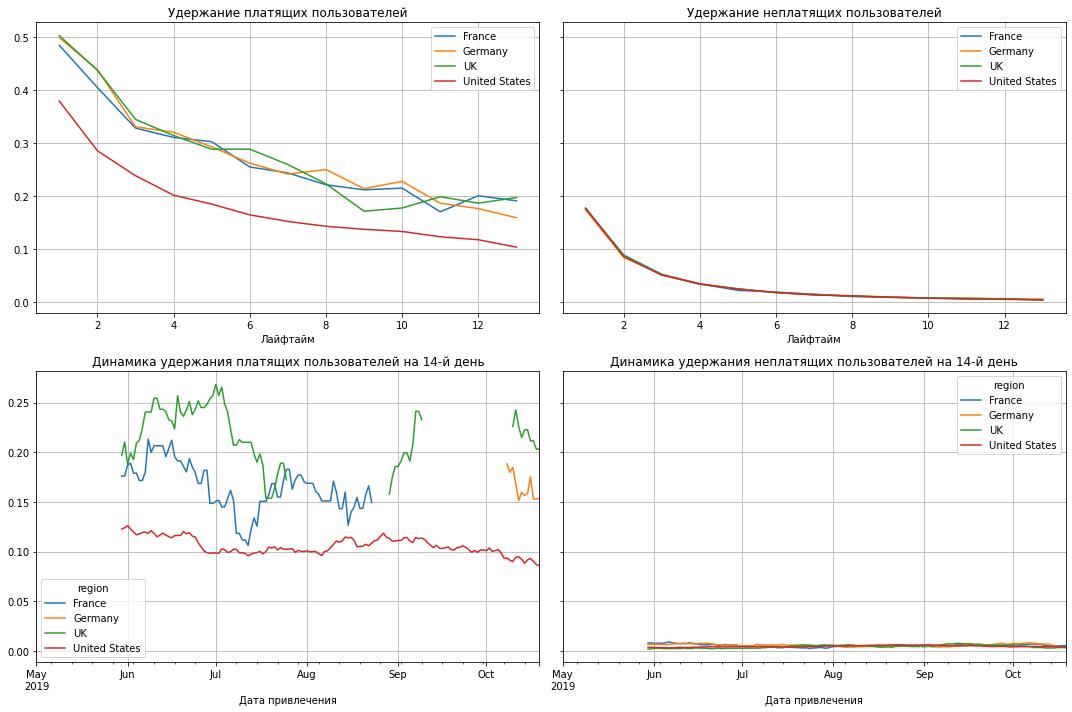

In [41]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region'], ignore_horizon=False
)


plot_retention(retention_grouped, retention_history, horizon_days) 

Видим, что пользователи из США явно плохо удерживаются.

**Вывод:**

В целом, реклама близка к окупемости.
Окупаемость могут снижать владельцы `Mac` и `iPhone`, страна - `США`. Не окупаются пользователи, привлеченные из каналов `LeapBop`, `FaceBoom`, `TipTop`.
Проблемы окупаемости могут быть вызваны неправильным распределением средств на рекламу (в какой-то источник вложено больше средств, чем в остальные, а он не оправдал надежд), также возможно, что горизонт анализа недостаточен для того, чтобы пользователи окупились.

## Шаг 6. ВЫВОД

Исследование проводилось на **150008** пользовательских профилях созданых из имеющихся данных за период с **1 мая** по **27 октября 2019года**. В приложение пользователи приходят из **4** стран: `Америка`, `Германия`, `Великобритания` и `Франция`. Наибольшая доля пользователей становится плательщиками в `Америке`. В приложение пользователи заходят с 4 устройств: `Mac`, `iPhone`, `Android`, `PC`.Самый эффективный канал привлечения платящих пользователей - `FaceBoom`, более **12** процентов пришедших с этого канала становятся плательщиками.

Общая сумма расходов на маркетинг - **105497.3у.е**. Со временем расходы растут. Наибольшие суммы для привлечения клиентов по двум каналам `FaceBoom` и `TipTop`. Остальные каналы привлечения обходятся довольно дешево. По всем источникам кроме `TipTop` средняя стоимость привлечения стабильна на протяжении всего исследуемого периода. А вот канал привлечения `TipTop` очень интересный. мало того что средняя стоимость привлечения на нем выше чем на других площадках, так еще есть резкие скачки с повышением. Возможно это связано с тем что платформа развивается. становится все популярнее. соответственно стоимость рекламы увеличивается.

 Реклама не окупается к концу 2й недели. ROI — около 80%. Рекламный бюджет увеличивается с течением времени.
Окупаемость могут снижать владельцы `Mac` и `iPhone`, страна - `США`. Не окупаются пользователи, привлеченные из каналов `LeapBop`, `FaceBoom`, `TipTop`.
Проблемы окупаемости могут быть вызваны неправильным распределением средств на рекламу (в какой-то источник вложено больше средств, чем в остальные, а он не оправдал надежд), также возможно, что горизонт анализа недостаточен для того, чтобы пользователи окупились.

**Рекомендации для отдела маркетинга:**

- Направить внимание по окупаемости следует на владельцев `Mac` и `iPhone` - стоимость их привлечения высока (и растет от месяца к месяцу), а окупаемоcть страдает. Возможно, стоит сделать какое-то маркетинговое предложение именно для владельцев устройств на базе этих ОС, чтобы они приносили продукту бОльшую денежную ценность.

- При том что большая часть пользователей приходит из США в целом уровень окупаемости по этой стране низкий. Причем окупаемость пользователей начала падать с июля - стоит также разобраться, что могло послужить причиной. При этом стоимость привлечения пользователей из Америки - самая высокая. Поэтому стоит также пересмотреть траты на рекламу в этой стране и возможно добавить рекламный бюджет более окупаемым странам. Лучше всего окупается Англия и Германия. Возможно, стоит попробовать закупить больше трафика, целясь на эту аудиторию.

-   Виден большой рост стоимости привлечения пользователей из рекламного канала `TipTop`. Кажется, слишком много средств было потрачено на эту рекламную сеть, но она себя не оправдала. Возможно, стоит уменьшить бюджет, выделяемый на эту сеть и перенаправить его на более эффективный канал.

- Не окупаются пользватели, привлеченные из каналов `LeapBop`, `FaceBoom`, `TipTop`. Остальные каналы привлечения обходятся довольно дешево. Плохо удерживаются пользователи из каналов `FaceBoom` и `AdNonSense`. Можно попробовать переключить внимание на более дешевые, но прибыльные каналы.